# Quickstart: Building a GenAI powered Semantic Data Model with Intugle

This quickstart shows you how to use Intugle’s open-source library to transform fragmented datasets into a connected semantic model. The semantic model captures profiling, relationships, and business meaning of your data — making it instantly usable for exploration, search, and data product creation.

**What is a Semantic Model?**

A semantic model is an intelligent knowledge graph of your data. It connects tables, discovers relationships, and enriches them with business glossaries — so both data teams and business users can query with clarity, not complexity.

**Who is this for?**

*   **Data Engineers & Architects** often spend weeks manually profiling, classifying, and stitching together fragmented data assets. With Intugle, they can automate this process end-to-end, uncovering meaningful links and relationships to instantly generate a connected semantic layer.
*   **Data Analysts & Scientists** spend endless hours on data readiness and preparation before they can even start the real analysis. Intugle accelerates this by providing contextual intelligence, automatically generating SQL and reusable data products enriched with relationships and business meaning.
*   **Business Analysts & Decision Makers** are slowed down by constant dependence on technical teams for answers. Intugle removes this bottleneck by enabling natural language queries and semantic search, giving them trusted insights on demand.

**In this notebook, you will learn how to:**

*   **Generate Semantic Model** → The unified layer that transforms fragmented datasets, creating the foundation for connected intelligence.
    *   **1.1 Profile and classify data** → Analyze your data sources to understand their structure, data types, and other characteristics.
    *   **1.2 Discover links & relationships among data** → Reveal meaningful connections (PK & FK) across fragmented tables.
    *   **1.3 Generate a business glossary** → Create business-friendly terms and use them to query data with context.
    *   **1.4 Enable Semantic search** → Intelligent search that understands meaning, not just keywords—making data more accessible across both technical and business users.
    *   **1.5 Visualize semantic model** → Get access to enriched metadata of the semantic model and visualize your data and relationships.
*   **Build Unified Data Products** → Simply pick the attributes across your data tables, and let the toolkit auto-generate queries with all the required joins, transformations, and aggregations using the semantic layer. When executed, these queries produce reusable data products.

Before you start, make sure you install the **Intugle Data Tools**:

In [ ]:
CREATE OR REPLACE NETWORK RULE pypi_network_rule
MODE = EGRESS
TYPE = HOST_PORT
VALUE_LIST = ('pypi.org', 'pypi.python.org', 'pythonhosted.org', 'files.pythonhosted.org');

CREATE OR REPLACE NETWORK RULE nltk_network_rule
MODE = EGRESS
TYPE = HOST_PORT
VALUE_LIST = ('raw.githubusercontent.com');

CREATE OR REPLACE NETWORK RULE duckdb_download_rule
MODE = EGRESS
TYPE = HOST_PORT
VALUE_LIST = ('extensions.duckdb.org:80');

CREATE OR REPLACE NETWORK RULE openai_rule
  MODE = EGRESS
  TYPE = HOST_PORT
  VALUE_LIST = ('api.openai.com');



In [ ]:
CREATE OR REPLACE EXTERNAL ACCESS INTEGRATION intugle_integration
ALLOWED_NETWORK_RULES = (pypi_network_rule, nltk_network_rule, duckdb_download_rule, openai_rule)
ENABLED = true;


GRANT USAGE ON INTEGRATION intugle_integration TO ROLE SNOWFLAKE_LEARNING_ROLE;

In [ ]:
%pip install intugle[snowflake]

## 1. LLM Configuration

Before running the project, you need to configure a Large Language Model (LLM). This is used for tasks like generating business glossaries and predicting links between tables. For the semantic search feature, you will also need to set up Qdrant and provide an OpenAI API key. For detailed setup instructions, please refer to the [README.md](README.md) file.

You can configure the necessary services by setting the following environment variables:

*   `LLM_PROVIDER`: The LLM provider and model to use (e.g., `openai:gpt-3.5-turbo`). The format follows langchain's format for initializing chat models. Checkout how to specify your model [here](https://python.langchain.com/docs/integrations/chat/)
*   `API_KEY`: Your API key for the LLM provider. The exact name of the variable may vary from provider to provider (e.g., `OPENAI_API_KEY`, `ANTHROPIC_API_KEY`).

Here's an example of how to set these variables in your environment:

```bash
export LLM_PROVIDER="openai:gpt-3.5-turbo"
export OPENAI_API_KEY="your-openai-api-key"
```
Alternatively, you can set them in the notebook like this:

In [1]:
import os
from dotenv import load_dotenv


os.environ["LLM_PROVIDER"] = "openai:gpt-3.5-turbo"
os.environ["OPENAI_API_KEY"] = "your-openai-api-key"  # Replace with your actual key


# Load environment variables from .env file
load_dotenv(override=True)



> Currently the langchain packages for OpenAI, Anthropic and Gemini is installed by default. For additional models, make sure you have the integration packages installed. E.g. you should have langchain-deepseek installed to use a DeepSeek model. You can get these packages here: [LangChain Chat Models](https://python.langchain.com/docs/integrations/chat/)

## 2. Building the Semantic Model

The `SemanticModel` is the entry point for building your semantic layer. It takes a dictionary of datasets as input and performs the following steps:

1.  **Data Profiling:** Calculates statistics for each column, such as distinct count, uniqueness, and completeness.
2.  **Datatype Identification:** Identifies the data type of each column (e.g., integer, string, datetime).
3.  **Key Identification:** Identifies potential primary keys.
4.  **Glossary Generation:** Generates a business glossary for each column using an LLM.
5.  **Link Prediction:** Predicts the relationships (foreign keys) between tables.

Let's start by defining the datasets we want to use. The path shown below can be a local file path or a remote URL.

> For this demo, we will be using the technology manufacturing dataset which can be found under [sample_data/tech_manufacturing](https://github.com/Intugle/data-tools/blob/main/notebooks/quickstart_native_snowflake.ipynb) in the repo

In [2]:
def generate_config(table_name: str) -> str:
    """Append the base URL to the table name."""
    return {
        "identifier": table_name,
    }


table_names = \
[
    "CAMPAIGNS",
    "CAMPAIGN_SURVEY",
    "CUSTOMER_HIERARCHY",
    "CUSTOMERS",
    "DELIVERY_SURVEY",
    "EXPENSE",
    "INSTALL_BASE",
    "INVENTORY",
    "LOGISTICS",
    "NPS_SURVEY",
    "OPPORTUNITY",
    "ORDERS",
    "PROB_STATEMENT_ISSUE",
    "PRODUCT_FEATURE",
    "PRODUCT_HIERARCHY",
    "PRODUCTS",
    "RENEWALS",
    "RETURNS",
    "SERVICE_REQUESTS",
    "WEBSITE",
]


datasets = {table: generate_config(table) for table in table_names}

Now, let's use the `SemanticModel` to build our semantic layer:

> The `domain` parameter helps the LLM generate a more contextual business glossary. It specifies the industry domain that the dataset belongs to (e.g., "Healthcare", "Finance", "E-commerce").

In [4]:
from intugle import SemanticModel

# Initialize the semantic model
sm = SemanticModel(datasets, domain="Technology Manufacturing Company")

# Run the prediction
sm.build()

Found existing YAML for 'ALLERGIES'. Checking for staleness.
ALLERGIES loaded
CAREPLANS loaded
Found existing YAML for 'CLAIMS'. Checking for staleness.
CLAIMS loaded
ENCOUNTERS loaded
Found existing YAML for 'PATIENTS'. Checking for staleness.
PATIENTS loaded
PAYERS loaded
PAYER_TRANSITIONS loaded
PROCEDURES loaded
SUPPLIES loaded


Starting profiling and key identification stage...

Dataset 'ALLERGIES' already profiled. Skipping.


Processing dataset: CAREPLANS

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] CAREPLANS:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/intugle/data-tools/src/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] CAREPLANS: 100%|██████████| 1/1 [04:03<00:00, 243.27s/it]

Dataset 'CLAIMS' already profiled. Skipping.


Processing dataset: ENCOUNTERS

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] ENCOUNTERS:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/intugle/data-tools/src/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] ENCOUNTERS: 100%|██████████| 1/1 [01:05<00:00, 65.26s/it]

Dataset 'PATIENTS' already profiled. Skipping.


Processing dataset: PAYERS

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] PAYERS:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/intugle/data-tools/src/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] PAYERS: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Processing dataset: PAYER_TRANSITIONS

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] PAYER_TRANSITIONS:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/intugle/data-tools/src/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[!]  key identified by LLM is not a valid column of PAYER_TRANSITIONS table
[*] PAYER_TRANSITIONS: 100%|██████████| 1/1 [00:03<00:00,  3.27s/it]


Processing dataset: PROCEDURES

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 9/9 [00:04<00:00,  1.95it/s]


Processing dataset: SUPPLIES

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 6/6 [00:03<00:00,  1.97it/s]


Profiling and key identification complete.

Starting link prediction stage...

Dataset 'ALLERGIES' already processed. Skipping analysis.
Dataset 'CAREPLANS' already processed. Skipping analysis.
Dataset 'CLAIMS' already processed. Skipping analysis.
Dataset 'ENCOUNTERS' already processed. Skipping analysis.
Dataset 'PATIENTS' already processed. Skipping analysis.
Dataset 'PAYERS' already processed. Skipping analysis.
Dataset 'PAYER_TRANSITIONS' already processed. Skipping analysis.
Dataset 'PROCEDURES' already processed. Skipping analysis.
Dataset 'SUPPLIES' already processed. Skipping analysis.
LinkPredictor initialized with datasets: ['ALLERGIES', 'CAREPLANS', 'CLAIMS', 'ENCOUNTERS', 'PATIENTS', 'PAYERS', 'PAYER_TRANSITIONS', 'PROCEDURES', 'SUPPLIES']

--- Comparing 'ALLERGIES' <=> 'CAREPLANS' ---


[*] ALLERGIES <==> CAREPLANS Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


No links found for this pair.

--- Comparing 'ALLERGIES' <=> 'CLAIMS' ---


[*] ALLERGIES <==> CLAIMS Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


No links found for this pair.

--- Comparing 'ALLERGIES' <=> 'ENCOUNTERS' ---


[*] ALLERGIES <==> ENCOUNTERS Runs:1: 100%|██████████| 1/1 [00:07<00:00,  7.25s/it]


No links found for this pair.

--- Comparing 'ALLERGIES' <=> 'PATIENTS' ---


[*] ALLERGIES <==> PATIENTS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


Found 1 potential link(s).

--- Comparing 'ALLERGIES' <=> 'PAYERS' ---


[*] ALLERGIES <==> PAYERS Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


No links found for this pair.

--- Comparing 'ALLERGIES' <=> 'PAYER_TRANSITIONS' ---


[*] ALLERGIES <==> PAYER_TRANSITIONS Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


No links found for this pair.

--- Comparing 'ALLERGIES' <=> 'PROCEDURES' ---


[*] ALLERGIES <==> PROCEDURES Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


No links found for this pair.

--- Comparing 'ALLERGIES' <=> 'SUPPLIES' ---


[*] ALLERGIES <==> SUPPLIES Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


No links found for this pair.

--- Comparing 'CAREPLANS' <=> 'CLAIMS' ---


[*] CAREPLANS <==> CLAIMS Runs:1: 100%|██████████| 1/1 [00:13<00:00, 13.74s/it]


No links found for this pair.

--- Comparing 'CAREPLANS' <=> 'ENCOUNTERS' ---


[*] CAREPLANS <==> ENCOUNTERS Runs:1: 100%|██████████| 1/1 [00:28<00:00, 28.05s/it]


No links found for this pair.

--- Comparing 'CAREPLANS' <=> 'PATIENTS' ---


[*] CAREPLANS <==> PATIENTS Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it]


Found 1 potential link(s).

--- Comparing 'CAREPLANS' <=> 'PAYERS' ---


[*] CAREPLANS <==> PAYERS Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


No links found for this pair.

--- Comparing 'CAREPLANS' <=> 'PAYER_TRANSITIONS' ---


[*] CAREPLANS <==> PAYER_TRANSITIONS Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


No links found for this pair.

--- Comparing 'CAREPLANS' <=> 'PROCEDURES' ---


[*] CAREPLANS <==> PROCEDURES Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it]


No links found for this pair.

--- Comparing 'CAREPLANS' <=> 'SUPPLIES' ---


[*] CAREPLANS <==> SUPPLIES Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


No links found for this pair.

--- Comparing 'CLAIMS' <=> 'ENCOUNTERS' ---


[*] CLAIMS <==> ENCOUNTERS Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.41s/it]


Found 1 potential link(s).

--- Comparing 'CLAIMS' <=> 'PATIENTS' ---


[*] CLAIMS <==> PATIENTS Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.27s/it]


Found 1 potential link(s).

--- Comparing 'CLAIMS' <=> 'PAYERS' ---


[*] CLAIMS <==> PAYERS Runs:1: 100%|██████████| 1/1 [00:06<00:00,  6.72s/it]


No links found for this pair.

--- Comparing 'CLAIMS' <=> 'PAYER_TRANSITIONS' ---


[*] CLAIMS <==> PAYER_TRANSITIONS Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


No links found for this pair.

--- Comparing 'CLAIMS' <=> 'PROCEDURES' ---


[*] CLAIMS <==> PROCEDURES Runs:1: 100%|██████████| 1/1 [00:30<00:00, 30.76s/it]


No links found for this pair.

--- Comparing 'CLAIMS' <=> 'SUPPLIES' ---


[*] CLAIMS <==> SUPPLIES Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.56s/it]


No links found for this pair.

--- Comparing 'ENCOUNTERS' <=> 'PATIENTS' ---


[*] ENCOUNTERS <==> PATIENTS Runs:1: 100%|██████████| 1/1 [00:06<00:00,  6.35s/it]


Found 1 potential link(s).

--- Comparing 'ENCOUNTERS' <=> 'PAYERS' ---


[*] ENCOUNTERS <==> PAYERS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


Found 1 potential link(s).

--- Comparing 'ENCOUNTERS' <=> 'PAYER_TRANSITIONS' ---


[*] ENCOUNTERS <==> PAYER_TRANSITIONS Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


No links found for this pair.

--- Comparing 'ENCOUNTERS' <=> 'PROCEDURES' ---


[*] ENCOUNTERS <==> PROCEDURES Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


Found 1 potential link(s).

--- Comparing 'ENCOUNTERS' <=> 'SUPPLIES' ---


[*] ENCOUNTERS <==> SUPPLIES Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it]


No links found for this pair.

--- Comparing 'PATIENTS' <=> 'PAYERS' ---


[*] PATIENTS <==> PAYERS Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


No links found for this pair.

--- Comparing 'PATIENTS' <=> 'PAYER_TRANSITIONS' ---


[*] PATIENTS <==> PAYER_TRANSITIONS Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.76s/it]


Found 1 potential link(s).

--- Comparing 'PATIENTS' <=> 'PROCEDURES' ---


[*] PATIENTS <==> PROCEDURES Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


Found 1 potential link(s).

--- Comparing 'PATIENTS' <=> 'SUPPLIES' ---


[*] PATIENTS <==> SUPPLIES Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


Found 1 potential link(s).

--- Comparing 'PAYERS' <=> 'PAYER_TRANSITIONS' ---


[*] PAYERS <==> PAYER_TRANSITIONS Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.80s/it]


Found 1 potential link(s).

--- Comparing 'PAYERS' <=> 'PROCEDURES' ---


[*] PAYERS <==> PROCEDURES Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


No links found for this pair.

--- Comparing 'PAYERS' <=> 'SUPPLIES' ---


[*] PAYERS <==> SUPPLIES Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


No links found for this pair.

--- Comparing 'PAYER_TRANSITIONS' <=> 'PROCEDURES' ---


[*] PAYER_TRANSITIONS <==> PROCEDURES Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


No links found for this pair.

--- Comparing 'PAYER_TRANSITIONS' <=> 'SUPPLIES' ---


[*] PAYER_TRANSITIONS <==> SUPPLIES Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


No links found for this pair.

--- Comparing 'PROCEDURES' <=> 'SUPPLIES' ---


[*] PROCEDURES <==> SUPPLIES Runs:1: 100%|██████████| 1/1 [00:16<00:00, 16.81s/it]

No links found for this pair.


Link prediction complete.

Starting business glossary generation stage...

Glossary for 'ALLERGIES' already exists. Skipping.

Generating glossary for dataset: CAREPLANS

100%|██████████| 9/9 [00:15<00:00,  1.68s/it]


Glossary for 'CLAIMS' already exists. Skipping.

Generating glossary for dataset: ENCOUNTERS

100%|██████████| 15/15 [00:20<00:00,  1.36s/it]


Glossary for 'PATIENTS' already exists. Skipping.

Generating glossary for dataset: PAYERS

100%|██████████| 21/21 [00:29<00:00,  1.40s/it]


Generating glossary for dataset: PAYER_TRANSITIONS

100%|██████████| 8/8 [00:11<00:00,  1.41s/it]


Generating glossary for dataset: PROCEDURES

100%|██████████| 9/9 [00:12<00:00,  1.34s/it]


Generating glossary for dataset: SUPPLIES

100%|██████████| 6/6 [00:08<00:00,  1.33s/it]


Business glossary generation complete.

Initializing semantic search...


/home/raphael/intugle/data-tools/src/intugle/core/vector_store/qdrant.py:77: UserWarning: Api key is used with an insecure connection.
  self._client = AsyncQdrantClient(**self.client_config)


Semantic search initialized.


## 3. Accessing Enriched Metadata

Now that the semantic model is built, you can easily access the enriched metadata for each dataset.

### Accessing a Dataset

You can access a specific dataset by its name from the `sm.datasets` dictionary:

In [5]:
patients_dataset = sm.datasets['PRODUCTS']
patients_dataset.profiling_df

,column_name,table_name,business_name,datatype_l1,datatype_l2,business_glossary,business_tags,count,null_count,distinct_count,uniqueness,completeness,sample_data
0,ID,PATIENTS,id,alphanumeric,dimension,Serves as a unique identifier for individuals ...,"[Patient Identifier, Unique Identifier, Health...",1163,0,1163,1.000000,1.000000,"[fed745aa-0d47-4eb7-58e0-5d132b90a24f, ccfc4db..."
1,BIRTHDATE,PATIENTS,birthdate,date & time,dimension,Indicates the date on which an individual was ...,"[Patient Demographics, Date Of Birth, Age Calc...",1163,0,987,0.848667,1.000000,"[1967-01-30, 1969-10-19, 1959-07-24, 2006-07-0..."
2,DEATHDATE,PATIENTS,deathdate,date & time,dimension,Date associated with the end of an individual'...,"[Patient Mortality Tracking, End Of Life Date,...",1163,1000,164,0.141015,0.140155,"[2008-07-04, 2006-11-17, 2002-02-01, 1996-05-1..."
3,SSN,PATIENTS,ssn,alphanumeric,dimension,Serves as a unique identifier for individuals ...,"[Personal Identification, Patient Record Linki...",1163,0,1163,1.000000,1.000000,"[999-24-1375, 999-71-1856, 999-40-8176, 999-11..."
4,DRIVERS,PATIENTS,drivers,alphanumeric,dimension,Indicates the unique identifier or status rela...,"[Patient Identification, Healthcare System Dri...",1163,215,942,0.809974,0.815133,"[S99912542, S99913091, S99920464, S99911315, S..."
5,PASSPORT,PATIENTS,passport,alphanumeric,dimension,Unique identifier used to document official tr...,"[Identity Verification, Travel Documentation, ...",1163,276,888,0.763543,0.762683,"[X4451825X, X87002556X, X56072907X, X64916399X..."
6,PREFIX,PATIENTS,prefix,close_ended_text,dimension,Indicates the title or honorific used to addre...,"[Patient Salutation, Personal Title, Demograph...",1163,245,4,0.003439,0.789338,"[None, Mr., Mrs., Ms.]"
7,FIRST,PATIENTS,first,alphanumeric,dimension,Identifies the given name of individuals in th...,"[PatientFirstName, PersonalIdentification, Hea...",1163,0,1002,0.861565,1.000000,"[Weston546, Sunni15, Elvin140, Trinh357, Antio..."
8,LAST,PATIENTS,last,alphanumeric,dimension,Identifies the surname or family name associat...,"[Patient Identifier, Unique Code, Healthcare R...",1163,0,477,0.410146,1.000000,"[Wintheiser220, Bartell116, Powlowski563, Hart..."
9,SUFFIX,PATIENTS,suffix,close_ended_text,dimension,Indicates the professional or academic designa...,"[Professional Credentials, Patient Identificat...",1163,1147,4,0.003439,0.013758,"[JD, None, MD, PhD]"


The profiling results can be accessed through the `profiling_df` property of the `DataSet` object. It's a pandas DataFrame that you can easily explore. 
> The business glossary is also available in the `profiling_df`:

### Visualizing Relationships

The `SemanticModel` automatically discovers the relationships between your tables. You can access the predicted links as a list of `PredictedLink` objects:

In [6]:
sm.links

[PredictedLink(from_dataset='ALLERGIES', from_column='PATIENT', to_dataset='PATIENTS', to_column='ID', intersect_count=179, intersect_ratio_from_col=1.0, intersect_ratio_to_col=0.154, accuracy=1.0),
 PredictedLink(from_dataset='CAREPLANS', from_column='PATIENT', to_dataset='PATIENTS', to_column='ID', intersect_count=552, intersect_ratio_from_col=1.0, intersect_ratio_to_col=0.475, accuracy=1.0),
 PredictedLink(from_dataset='CLAIMS', from_column='APPOINTMENTID', to_dataset='ENCOUNTERS', to_column='ID', intersect_count=1339, intersect_ratio_from_col=1.0, intersect_ratio_to_col=0.67, accuracy=1.0),
 PredictedLink(from_dataset='CLAIMS', from_column='PATIENTID', to_dataset='PATIENTS', to_column='ID', intersect_count=35, intersect_ratio_from_col=1.0, intersect_ratio_to_col=0.03, accuracy=1.0),
 PredictedLink(from_dataset='ENCOUNTERS', from_column='PATIENT', to_dataset='PATIENTS', to_column='ID', intersect_count=48, intersect_ratio_from_col=1.0, intersect_ratio_to_col=0.041, accuracy=1.0),
 Pr

You can also visualize these relationships as a graph. In case you run into an error, make sure you install/upgrade your ipykernel package:
> %pip install --upgrade ipykernel

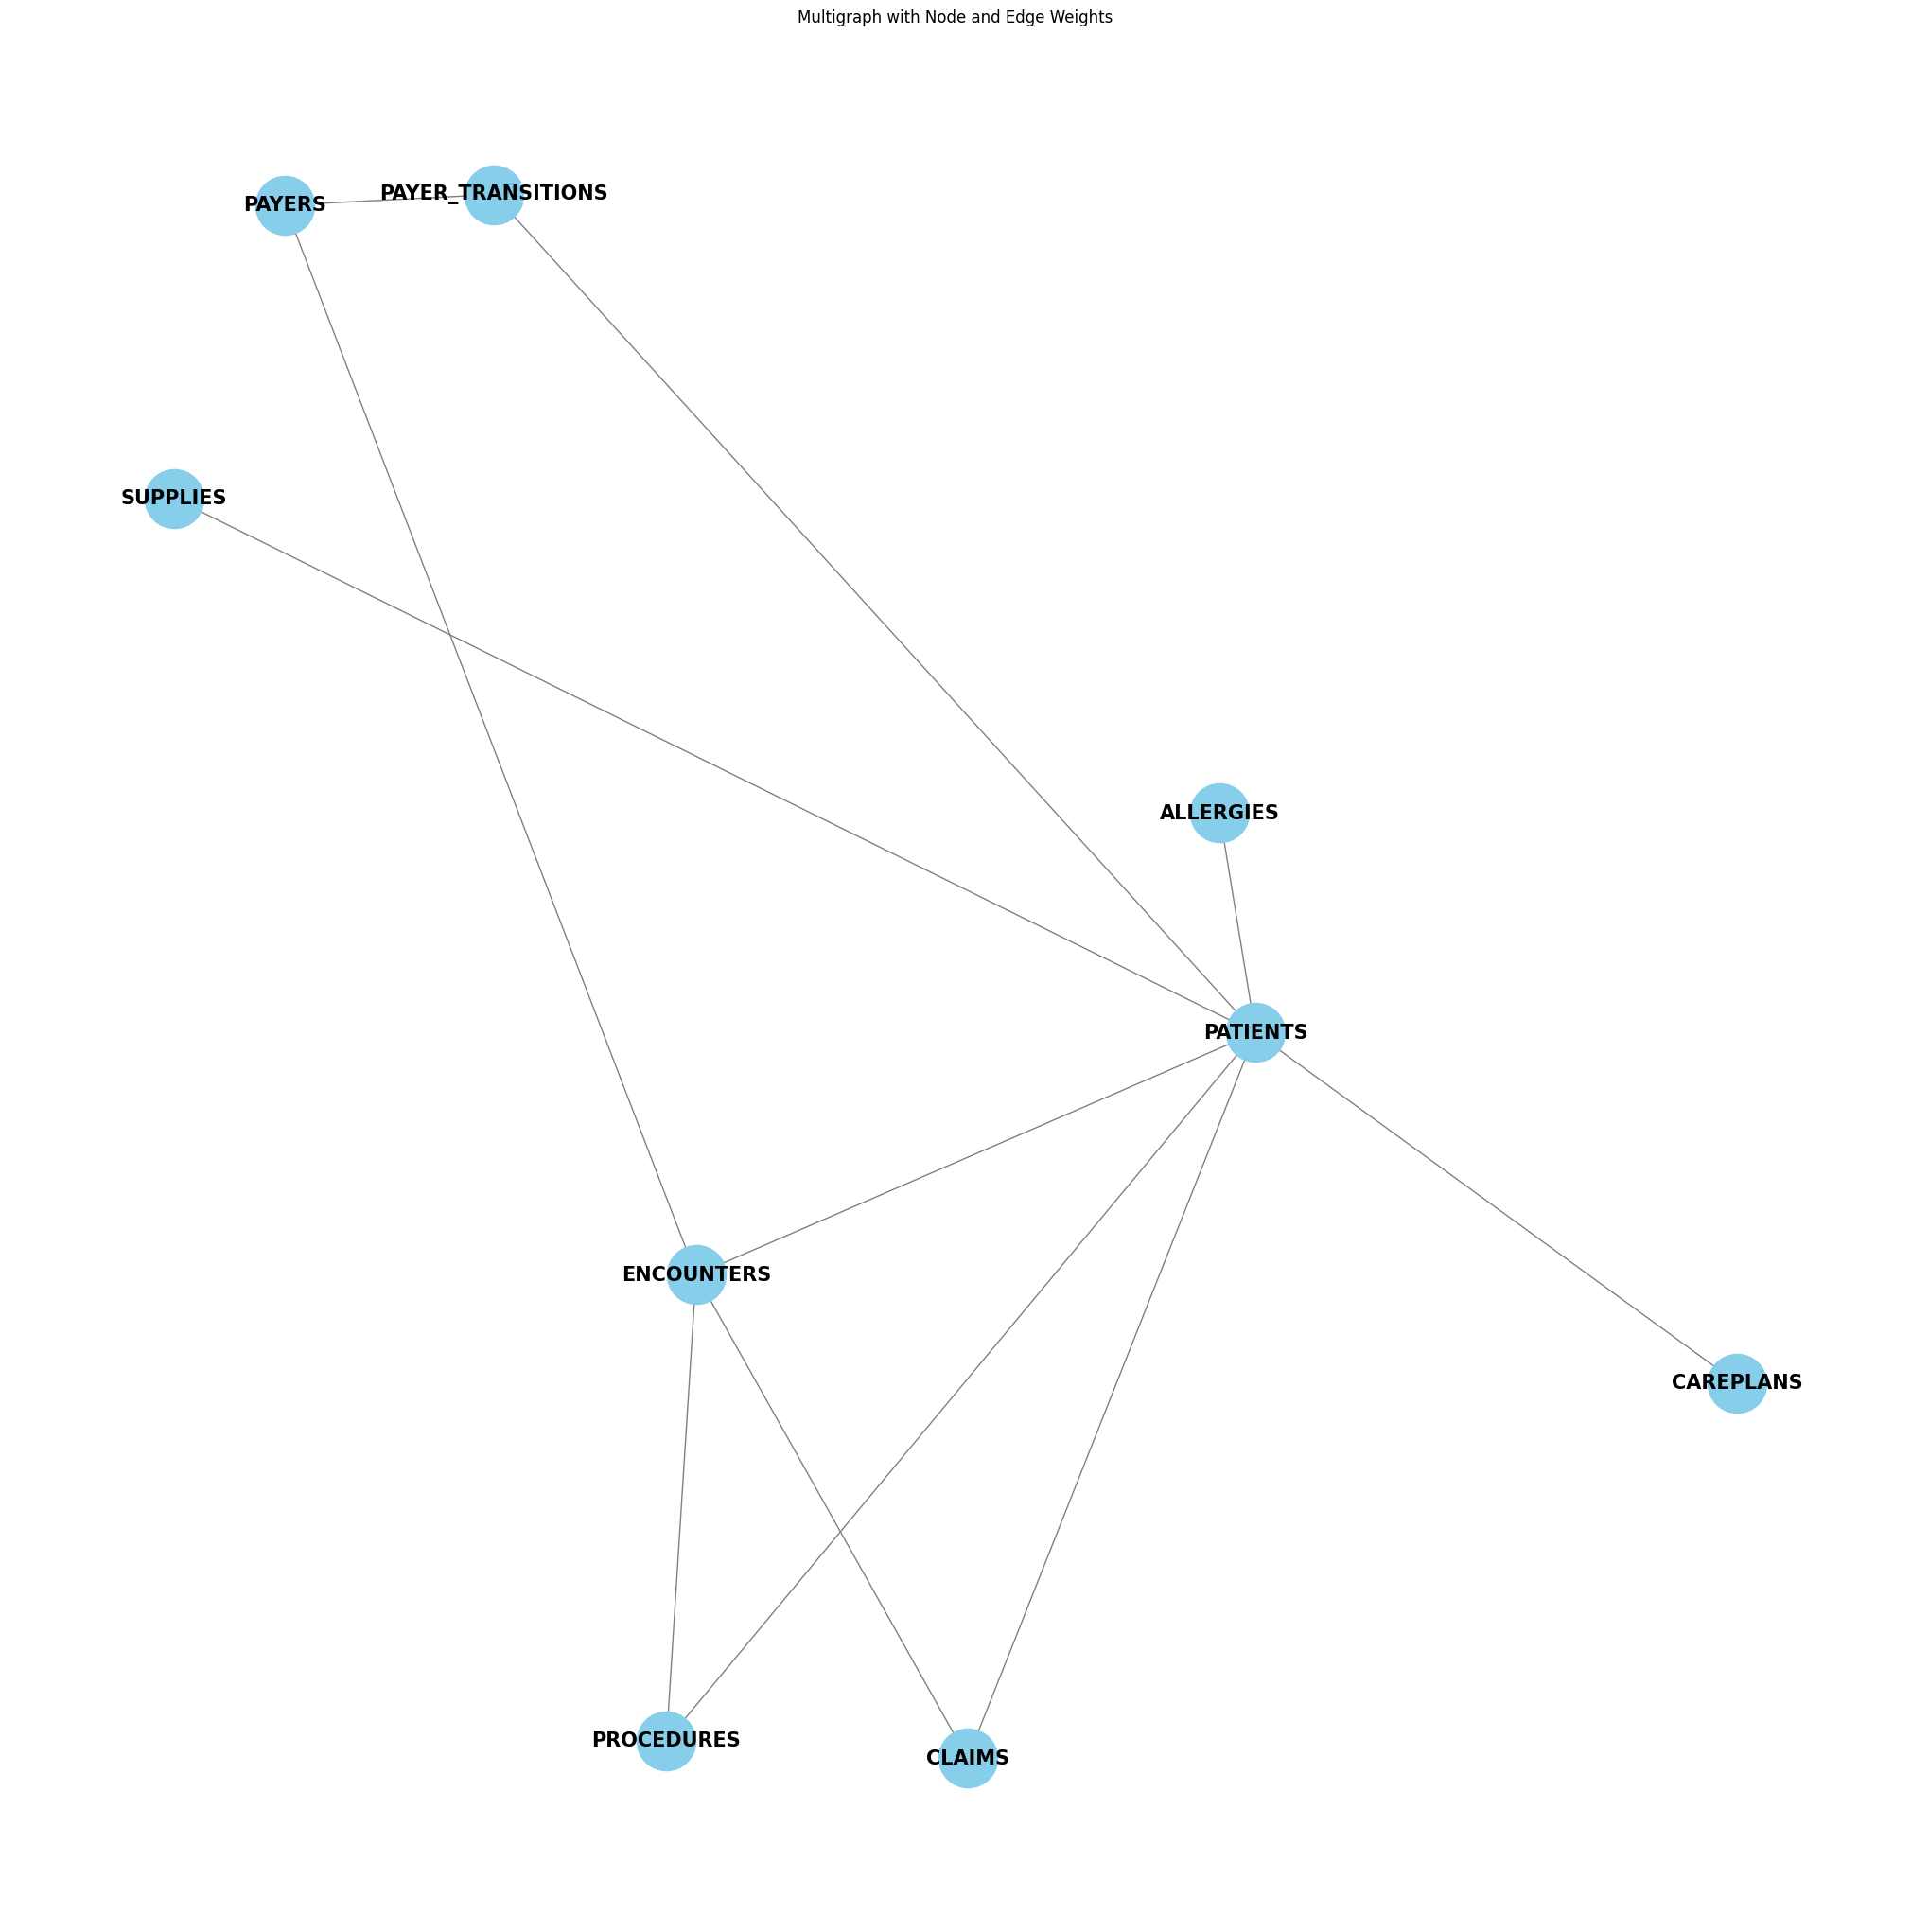

In [7]:
sm.visualize()  # To visualize the relationships as a graph

## 4. The Semantic Layer

The SemanticModel results are used to generate YAML files which are saved automatically. These files defines the semantic layer, including the models (tables) and their relationships. 

By default, these files are saved in the current working directory. You can configure this path by setting the `PROJECT_BASE` environment variable.

## 5. Deploying to Snowflake

Syncs the business glossaries with the source tables. Creates a semantic view in Snowflake complete with business glossaries, datatypes and relationships

In [ ]:
sm.deploy('snowflake')

You can also just create the YAML compatible with Snowflake Semantic Views:

In [9]:
sm.export(format="snowflake", path="snowflake_semantic_model.yml")

Successfully exported to snowflake_semantic_model.yml


{'name': 'intugle_generated_model',
 'description': 'Semantic model generated by Intugle',
 'tables': [{'name': 'PROCEDURES',
   'description': 'Tracks detailed information about procedures performed, including their timing, associated patients and encounters, procedural codes, descriptions, costs, and reasons for execution.',
   'base_table': {'database': 'SNOWFLAKE_LEARNING_DB',
    'schema': 'HEALTHCARE',
    'table': 'PROCEDURES'},
   'dimensions': [{'name': 'START_',
     'description': 'Marks the initiation timestamp of a procedure or activity.',
     'expr': '"START_"',
     'data_type': 'DATETIME',
     'unique': False},
    {'name': 'STOP',
     'description': 'Marks the conclusion timestamp of a specific procedure or activity.',
     'expr': '"STOP"',
     'data_type': 'DATETIME',
     'unique': False},
    {'name': 'PATIENT',
     'description': 'Identifies individuals associated with medical procedures for tracking and record-keeping purposes.',
     'expr': '"PATIENT"',
  

>Now that you have deployed a Semantic View, you can use **Snowflake Cortex Analyst** to **converse with your data** using natural language. Cortex Analyst leverages the relationships and context defined in your Semantic View to answer questions without requiring you to write SQL.
To get started, navigate to **AI & ML** -> **Cortex Analyst** in the **Snowflake UI** and select your newly created view.

## 6. Data Product Creation

The semantic layer serves as a foundation for the DataProduct, which streamlines the creation of reusable data products. This allows you
to encapsulate business logic and create standardized, trustworthy data assets that can be easily shared and reused across different teams and 
applications.

Let's define the model for the data product we want to build:

In [15]:
data_product_config = \
{
    "name": "customer_kpi_summary",
    "fields": [
        {
            "id": "CUSTOMERS.C_ID",
            "name": "c_id"
        },
        {
            "id": "CUSTOMERS.CUSTOMER_NAME",
            "name": "customer_name"
        },
        {
            "id": "CUSTOMER_HIERARCHY.\"global / parent account\"",
            "name": "global_parent_account"
        },
        {
            "id": "CUSTOMER_HIERARCHY.REGION",
            "name": "region"
        },
        {
            "id": "CUSTOMER_HIERARCHY.\"global / local entity\"",
            "name": "global_local_entity"
        },
        {
            "id": "PRODUCTS.PRODUCT_NAME",
            "name": "product_name"
        },
        {
            "id": "ORDERS.\"order value ($)\"",
            "name": "sum_order_value",
            "category": "measure",
            "measure_func": "sum"
        },
        {
            "id": "ORDERS.ORDER_ID",
            "name": "count_distinct_order_id",
            "category": "measure",
            "measure_func": "count"
        },
        {
            "id": "ORDERS.ORDER_QTY",
            "name": "sum_order_qty",
            "category": "measure",
            "measure_func": "sum"
        },
        {
            "id": "SERVICE_REQUESTS.SR_ID",
            "name": "count_distinct_sr_id",
            "category": "measure",
            "measure_func": "count"
        },
        {
            "id": "SERVICE_REQUESTS.PROD_ID",
            "name": "count_distinct_prod_id",
            "category": "measure",
            "measure_func": "count"
        },
        {
            "id": "RETURNS.R_ORDER_ID",
            "name": "count_distinct_r_order_id",
            "category": "measure",
            "measure_func": "count"
        },
        {
            "id": "NPS_SURVEY.SURVEY_SCORE",
            "name": "sum_survey_score",
            "category": "measure",
            "measure_func": "sum"
        }
    ]
}

Now, let's use the `DataProduct` to generate the data product:

In [16]:
from intugle import DataProduct

# Create a DataProduct
dp = DataProduct()

# Generate the data product
data_product = dp.build(data_product_config)

data_product.to_df()

Found existing YAML for 'PROCEDURES'. Checking for staleness.
PROCEDURES loaded
Found existing YAML for 'ALLERGIES'. Checking for staleness.
ALLERGIES loaded
Found existing YAML for 'ENCOUNTERS'. Checking for staleness.
ENCOUNTERS loaded
Found existing YAML for 'SUPPLIES'. Checking for staleness.
SUPPLIES loaded
Found existing YAML for 'PAYERS'. Checking for staleness.
PAYERS loaded
Found existing YAML for 'PAYER_TRANSITIONS'. Checking for staleness.
PAYER_TRANSITIONS loaded
Found existing YAML for 'PATIENTS'. Checking for staleness.
PATIENTS loaded
Found existing YAML for 'CLAIMS'. Checking for staleness.
CLAIMS loaded
Found existing YAML for 'CAREPLANS'. Checking for staleness.
CAREPLANS loaded
top_patients_by_claim_count loaded


,FIRST_NAME,LAST_NAME,NUMBER_OF_CLAIMS
0,Esther279,Runolfsson901,246
1,Zelda766,Ernser583,219
2,Bonita405,Bernier607,121
3,Pei116,Williamson769,98
4,Lavinia262,Heaney114,90
5,Magdalene960,Orn563,90
6,Tommye961,Simonis280,77
7,Franklyn361,Tromp100,71
8,Terry864,King743,69
9,Alaine226,Willms744,64


The `build` function returns a `DataSet` object. You can also view the generated SQL query used for creating the data product:

In [17]:
# The generated SQL query
data_product.sql_query

'SELECT "PATIENTS"."FIRST" as first_name, "PATIENTS"."LAST" as last_name, count("CLAIMS"."ID") as number_of_claims FROM CLAIMS LEFT JOIN PATIENTS ON "CLAIMS"."PATIENTID" = "PATIENTS"."ID" GROUP BY "PATIENTS"."FIRST" , "PATIENTS"."LAST" ORDER BY number_of_claims DESC LIMIT 10'

### Enriching the Data Product

The `data_product` is in itself a DataSet object. Hence we can run generate glossaries for it as well. 

In [18]:
data_product.run(domain="Healthcare")
data_product.profiling_df

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] top_patients_by_claim_count:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/intugle/data-tools/src/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[!] None key identified by LLM is not a valid column of top_patients_by_claim_count table
100%|██████████| 3/3 [00:04<00:00,  1.39s/it]


,column_name,table_name,business_name,datatype_l1,datatype_l2,business_glossary,business_tags,count,null_count,distinct_count,uniqueness,completeness,sample_data
0,FIRST_NAME,top_patients_by_claim_count,first_name,alphanumeric,L2OutputTypes.dimension,Identifies the given name of individuals liste...,"[Patient Identification, Healthcare Claims Ana...",10,0,10,1.0,1.0,"[Tommye961, Magdalene960, Alaine226, Bonita405..."
1,LAST_NAME,top_patients_by_claim_count,last_name,alphanumeric,L2OutputTypes.dimension,Identifies the family name of individuals list...,"[Patient Identification, Claims Analysis, Heal...",10,0,10,1.0,1.0,"[Bernier607, Runolfsson901, Simonis280, Willia..."
2,NUMBER_OF_CLAIMS,top_patients_by_claim_count,number_of_claims,integer,L2OutputTypes.measure,Indicates the total count of claims associated...,"[Claim Volume Analysis, Patient Utilization Me...",10,0,9,0.9,1.0,"[246, 90, 121, 77, 98, 69, 219, 71, 64]"


### Syncing with Snowflake Semantic View
Lets sync the data product with the Snowflake Semantic View as well

In [ ]:
sm.deploy('snowflake')

## Conclusion

You've learned how to:

*   Configure your LLM provider
*   Build a semantic model using the `SemanticModel`.
*   Access enriched metadata, business glossaries and visualize the relationships between your tables.
*   Generate data products from the semantic layer using the `DataProduct`.
*   Sync the semantic model with Snowflake Semantic Views

This is just a starting point. This project has many other features to explore. We encourage you to try it with your own data and see how it can help you build a powerful semantic layer.